In [1]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle

%matplotlib inline

In [2]:
X_train = idx2numpy.convert_from_file("./train-images.idx3-ubyte")
X_test = idx2numpy.convert_from_file("./t10k-images.idx3-ubyte")
y_train = idx2numpy.convert_from_file("./train-labels.idx1-ubyte")
y_test = idx2numpy.convert_from_file("./t10k-labels.idx1-ubyte")

In [3]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [4]:
def display(img):
    image_width = image_height = np.ceil(np.sqrt(img.shape[0])).astype(np.uint8)
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

In [5]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [6]:
labels_count = np.unique(y_train).shape[0]
y_train = dense_to_one_hot(y_train, labels_count)
y_test = dense_to_one_hot(y_test, labels_count)

In [139]:
class mlp_NN():
    func_set = ["Sigmoid", "Tanh", "ReLU", "ExpLin", "Softmax", "Linear"]
    loss_func_set = ['mse', 'cross-entropy']
    
    # Activation functions
    def sigmoid(self, z, deriv=False):
        z = np.maximum(-30, z)
        z = np.minimum(30, z)
        if deriv == False:
            return 1.0/(1.0 + np.exp(-z))
        else:
            return self.sigmoid_deriv(z)
    
    def sigmoid_deriv(self, z):
        return self.sigmoid(z) * (1.0-self.sigmoid(z))
    def tanh(self, z, deriv = False):
        if deriv == False:
            return np.tanh(z)
        else:
            return self.tanh_deriv(z)
        
    def tanh_deriv(self, z):
        return 1.0 - np.power(self.tanh(z), 2)
    def rectifier(self, z, deriv = False):
        if deriv == False:
            return np.maximum(np.zeros(z.shape),z)
        else:
            return np.float32(z>0)
        
    def explin(self, z, deriv = False):
        if deriv == False:
            return (z>0)*z + (z<=0)*(np.exp(z) - 1)
        else:
            return (z>0)*1 + (z<=0)*(np.exp(z))
        
    # Output functions    
    def linear(self, z, deriv = False):
        if deriv == False:
            return z
        else:
            return 1
        
    def softmax(self, z, deriv = False):
        if deriv == False:
            res = np.exp(z)
            return res / np.sum(res, axis = 1).reshape(res.shape[0], 1)
            # return e_x / div
        else:
            s = np.max(z, axis = 1)
            s = s[:, np.newaxis]
            e_x = np.exp(z - s)
            div = np.sum(e_x, axis = 1)
            div = div[:, np.newaxis]
            return e_x / div - e_x / (div)**2
    
    # Loss functions
    def mse(self, y_pred, y_true, deriv = False):
        return np.sum(np.average((y_pred - y_true)**2, axis = 0))
    def nll(self, y_pred, y_true, deriv = False):
        eps = 1e-4
        y_pred = np.maximum(eps, y_pred)
        y_pred = np.minimum(1-eps, y_pred)
        #actual = np.zeros(y_pred.shape)
        rows = y_pred.shape[0]
        #actual[np.arange(rows), np.argmax(y_true.astype(int))] = 1
        #print actual
        #vsota = actual * np.log(y_pred)
        return -1.0 / rows * np.sum(np.log(y_pred) * y_true)
    
    def act_function(self, function, mbatch, deriv = False):
        if function == 'Sigmoid':
            return self.sigmoid(mbatch, deriv)
        elif function == 'Tanh':
            return self.tanh(mbatch, deriv)
        elif function == 'ReLU':
            return self.rectifier(mbatch, deriv)
        elif function == 'ExpLin':
            return self.explin(mbatch, deriv)
        elif function == 'Linear':
            return self.linear(mbatch, deriv)
        elif function == 'Softmax':
            return self.softmax(mbatch, deriv)
        
    def loss_function(self, X, y):
        if self.loss == 'mse':
            return self.mse(X, y)
        elif self.loss == 'cross-entropy':
            return self.nll(X, y)
        
    def regul(self, w):
        if self.penalty == 'L1':
            return np.abs(self.C*w)
        elif self.penalty == 'L2':
            return self.C*np.power(w, 2)/2.0
        
    def regul_deriv(self, w):
        if self.penalty == 'L1':
            return np.sign(self.C*w)
        elif self.penalty == 'L2':
            return self.C*w
        
    
    def __init__(self, layers, batch_size = 0, verbose = False, learning_rate = 1.0,
                 n_iter = 1000, loss = 'cross-entropy', penalty = 'L2', C = 1.0):
        """
        layers - list of ('Sigmoid', 10, bias = False)-like tuples
        verbose - gradient change printing
        learning_rate - multiplier of gradient change
        n_iter = number of iterations
        loss - loss function
        """
        self.ready = True
        self.batch_size = batch_size
        self.verbose = verbose
        self.lr_function = learning_rate
        self.n_iter = n_iter
        self.loss = loss
        self.layers = layers
        self.weights = []
        self.biases = []
        self.outputs = [0]*(len(layers)+1)
        self.inputs = [0]*(len(layers)+1)
        self.errors = [0]*(len(layers)+1)
        self.penalty = penalty
        self.C = C
        self.errors_plot = []
        self.grad_plot = []
        if len(self.layers) == 0:
            print "There must be at least output layer"
            self.ready = False#
        else:
            for num, layer in enumerate(self.layers):
                if layer[0] not in self.func_set and num != len(self.layers) - 1:
                    print "Layer must be from set ", self.func_set
                    self.ready = False
            if self.loss not in self.loss_func_set:
                print "Unknown loss function"
                self.ready = False
    
    def fit(self, X, y):
        if not self.ready:
            print "Network isn't ready."
        else:
            if self.batch_size == 0:
                self.batch_size = X.shape[0] + 1
            current_layer_size = X.shape[1]
            for num, layer in enumerate(self.layers):
                if num == len(self.layers) - 1:
                    self.weights.append(np.random.randn(current_layer_size, y.shape[1]) / np.sqrt(current_layer_size))
                    if self.layers[num-1][2] == True:
                        self.biases.append(np.random.rand(1, y.shape[1]) - 0.5)
                    else:
                        self.biases.append(np.zeros((1, y.shape[1])))
                else:
                    self.weights.append(np.random.randn(current_layer_size, layer[1]) / np.sqrt(current_layer_size))
                    current_layer_size = layer[1]
                    if layer[2] == True: # bias
                        self.biases.append(np.random.rand(1, current_layer_size) - 0.5)
                    else: # no bias
                        self.biases.append(np.zeros((1, current_layer_size)))
                self.grad_plot.append([])

            # Fitting
            epoch = 0
            while epoch < self.n_iter:
                self.learning_rate = self.lr_function(epoch)
                # Feed-forward
                X, y = shuffle(X, y)
                mini_batch = X[:self.batch_size]
                y_mini_batch = y[:self.batch_size]
                self.outputs[0] = mini_batch
                self.feed_forward(X, train = True)
                # Counting loss
                error = self.loss_function(self.outputs[len(self.layers)], y_mini_batch)
                self.errors_plot.append(error)
                if self.verbose and epoch % 25 == 0 and epoch > 0:
                    print 'Epoch', epoch, '\tloss:', error
                # Backprogapation
                self.backprop(y_mini_batch)
                epoch += 1
                
    def feed_forward(self, X, train = False):
        if train == False:
            for num, layer in enumerate(self.layers):
                X = np.dot(X, self.weights[num])
                X = self.act_function(layer[0], X + self.biases[num])
            return X
        else:
            for num, layer in enumerate(self.layers):
                self.inputs[num+1] = np.dot(self.outputs[num], self.weights[num]) + self.biases[num]
                output_temp = self.act_function(layer[0], self.inputs[num+1])
                self.outputs[num+1] = output_temp
                
    def backprop(self, y_mini_batch):
        # Last layer
        delta = self.outputs[len(self.layers)] - np.float32(y_mini_batch) # nll deriv * softmax deriv
        if self.loss == 'mse':
            delta = delta * self.act_function(self.layers[-1][0], self.inputs[-1], deriv = True)
        if self.layers[-1][2] == True: # last layer bias
            self.biases[-1] = self.biases[-1] - (self.learning_rate / self.batch_size) * np.average(delta, axis = 0).reshape(1, delta.shape[1])
        grad = np.dot(self.outputs[-2].T, delta)
        self.grad_plot[0].append(self.learning_rate * np.average(grad) / self.batch_size)
        self.weights[-1] = self.weights[-1] - (self.learning_rate / self.batch_size) * grad
        # Other layers
        for i in xrange(1, len(self.layers)):
            delta = np.dot(delta, self.weights[-i].T + self.regul_deriv(self.weights[-i].T))
            delta = delta * self.act_function(self.layers[-i-1][0], self.outputs[-i-1], deriv = True)
            if self.layers[-i-1][2] == True: # bias
                self.biases[-i-1] = self.biases[-i-1] - (self.learning_rate / self.batch_size) * np.average(delta, axis = 0).reshape(1, delta.shape[1])
            grad = np.dot(self.outputs[-i-2].T, delta)
            self.grad_plot[i].append(self.learning_rate * np.average(grad) / self.batch_size)
            self.weights[-i-1] = self.weights[-i-1] - (self.learning_rate / self.batch_size) * grad
            
    def grad_check(self, X, y):
        if self.ready:
            eps = 1e-3
            self.weights[-1] -= eps
            loss_before = self.loss_function(self.predict(X), y)
            print "Loss before: ",loss_before
            self.weights[-1] += (2.0 * eps)
            loss_after = self.loss_function(self.predict(X), y)
            print "Loss after: ", loss_after
            self.weights[-1] -= eps

            grad_num = (loss_after - loss_before) / (2.0 * eps)
            grad = np.average(self.grad_plot[num-1][-1])

            print "Numerical: ", grad_num
            print "Analytical: ", grad

            if not np.isclose(grad_num, grad, atol = eps):
                print 'Error! Numerical:', grad_num, 'Analytical:', grad
        else:
            print 'Network is not ready.'
                    
            
    def predict(self, X):
        y_pred = self.feed_forward(X, train = False)
        return y_pred

In [8]:
def lrate(epoch):
    # a1 = 0.02
    # a2 = 0.005
    # return 1.0 / np.pow(epoch, 0.5)
    # return a1 if epoch <= 60 else a2
    return 0.02

In [9]:
def test_accuracy(y_pred, y_true):
    return np.sum((np.array(y_pred) == np.array(y_true))) / float(np.array(y_pred).shape[0])

In [143]:
testnn = mlp_NN(batch_size = 350, learning_rate = lrate, n_iter = 140, loss = 'cross-entropy', penalty = 'L2',
                C = 0.0,
                layers = [('Sigmoid', 300, True),
                          #('Sigmoid', 400, True),
                          #('Sigmoid', 400, True),
                          ('Softmax', 10, True)],
                verbose = False)

In [144]:
testnn.fit(X_train, y_train)

График функции потерь

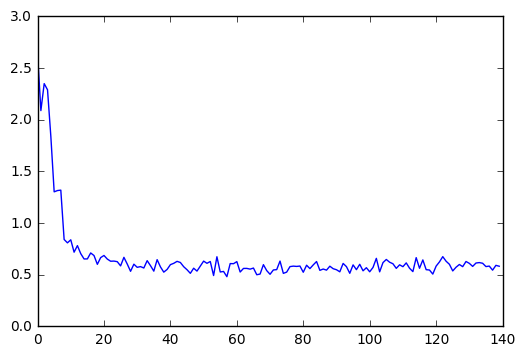

In [146]:
plt.plot(testnn.errors_plot)

In [145]:
print "%.4f" % test_accuracy(np.argmax(testnn.predict(X_test), axis = 1), np.argmax(y_test, axis = 1))

0.8736


График градиентов по слоям в зависимости от итерации

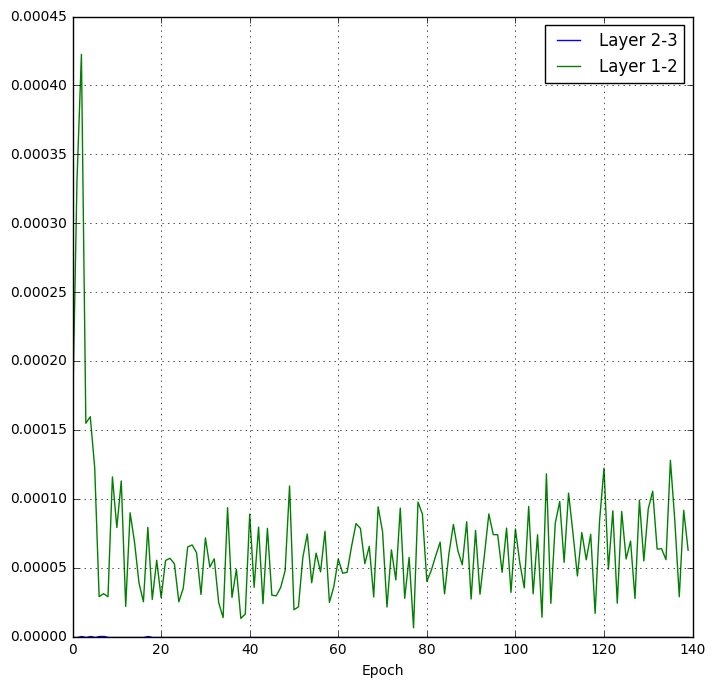

In [147]:
plt.figure(figsize=(8,8))
for num, grad in enumerate(testnn.grad_plot):
    plt.plot(np.abs(grad), label = 'Layer ' + str(len(testnn.layers) - num) + '-' + str(len(testnn.layers) + 1 - num))
plt.xlabel('Epoch')
plt.legend()
plt.grid()

In [148]:
testnn.grad_check(X_train, y_train)

Loss before:  0.588377048788
Loss after:  0.588377048788
Numerical:  0.0
Analytical:  -1.03536227211e-20


# Sanity check

XOR

In [36]:
size_Train = 500
XOR_original = np.array(np.random.randint(0,2, size = (size_Train,2)), dtype='float')
y_xor_train = np.array([int(n[0] != n[1]) for n in XOR_original])
y_xor_train = np.array([[0,1] if n == 1 else [1,0] for n in y_xor_train])
XOR_original += (np.random.random_sample((size_Train, 2)) - 0.5)*0.5

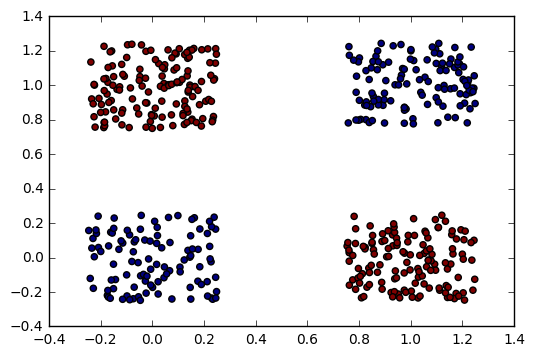

In [37]:
plt.scatter(XOR_original[:,0], XOR_original[:,1], c=np.argmax(y_xor_train, axis = 1))

In [38]:
size_test = 250
XOR_test = np.array(np.random.randint(0,2, size = (size_test,2)), dtype='float')
y_xor_test = np.array([int(n[0] != n[1]) for n in XOR_test])
y_xor_test = np.array([[0,1] if n == 1 else [1,0] for n in y_xor_test])
XOR_test += (np.random.random_sample((size_test, 2)) - 0.5)*0.5

In [39]:
xornn = mlp_NN(batch_size = 30, learning_rate = lambda x: 0.02, n_iter = 5000, loss = 'cross-entropy', penalty = 'L2',
               C = 0.0,
                layers = [('ReLU', 4, True),
                          ('Softmax', 2, True)],
                verbose = False)

In [40]:
xornn.fit(XOR_original, y_xor_train)

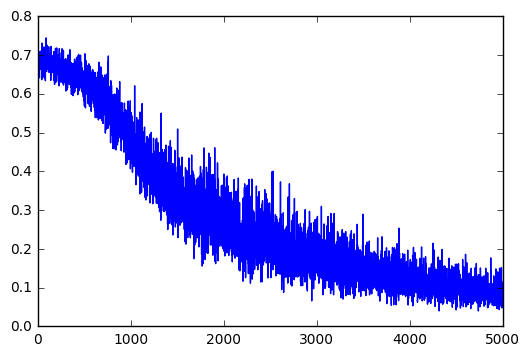

In [41]:
plt.plot(xornn.errors_plot)

In [42]:
test_accuracy(np.argmax(xornn.predict(XOR_test), axis = 1), np.argmax(y_xor_test, axis=1))

1.0

AND

In [43]:
size_Train = 500
AND_original = np.array(np.random.randint(0,2, size = (size_Train,2)), dtype='float')
y_and_train = np.array([int(n[0] == n[1] == 1) for n in AND_original])
y_and_train = np.array([[0,1] if n == 1 else [1,0] for n in y_and_train])
AND_original += (np.random.random_sample((size_Train, 2)) - 0.5)*0.5

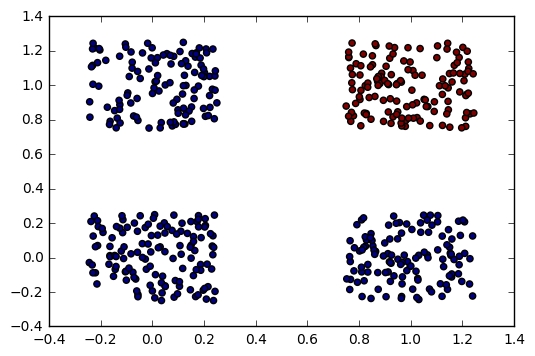

In [44]:
plt.scatter(AND_original[:,0], AND_original[:,1], c=np.argmax(y_and_train, axis = 1))

In [49]:
size_test = 250
AND_test = np.array(np.random.randint(0,2, size = (size_test,2)), dtype='float')
y_and_test = np.array([int(n[0] == n[1] == 1) for n in AND_test])
y_and_test = np.array([[0,1] if n == 1 else [1,0] for n in y_and_test])
AND_test += (np.random.random_sample((size_test, 2)) - 0.5)*0.5

In [95]:
andnn = mlp_NN(batch_size = 30, learning_rate = lambda x: 0.272, n_iter = 350, loss = 'cross-entropy', penalty = 'L2',
               C = 0.0,
                layers = [('Sigmoid', 10, True),
                          ('Softmax', 2, True)],
                verbose = False)

In [96]:
andnn.fit(AND_original, y_and_train)

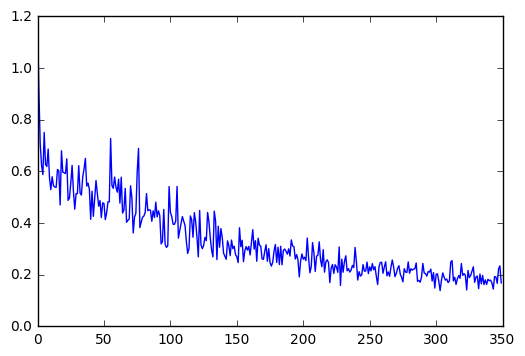

In [97]:
plt.plot(andnn.errors_plot)

In [98]:
test_accuracy(np.argmax(andnn.predict(AND_test), axis = 1), np.argmax(y_and_test, axis=1))

1.0

Three-class

In [99]:
size_Train = 500
TC_original = np.array(np.random.rand(size_Train, 2), dtype='float') - 0.5
y_tc_list = []
for elem in TC_original:
    if elem[0] > 0 and elem[0] > 2*elem[1]:
        y_tc_list.append(1)
    elif elem[0] <= 0 and -elem[0] > 2*elem[1]:
        y_tc_list.append(2)
    elif abs(elem[0]) <= 2*elem[1]:
        y_tc_list.append(3)
y_tc_train = np.array(y_tc_list)
y_tc_train = np.array([[1,0,0] if n == 1 else [0,1,0] if n == 2 else [0,0,1] for n in y_tc_train])

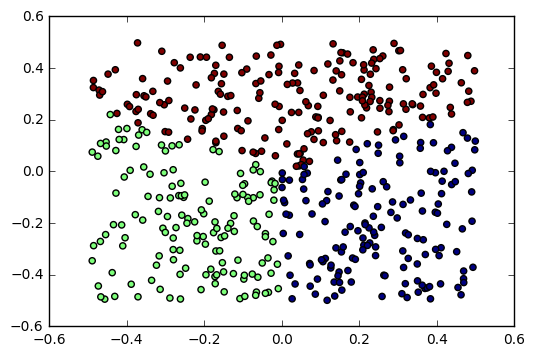

In [100]:
plt.scatter(TC_original[:,0], TC_original[:,1], c=np.argmax(y_tc_train, axis = 1))

In [101]:
size_test = 250
TC_test = np.array(np.random.rand(size_test, 2), dtype='float') - 0.5
y_tc_test_list = []
for elem in TC_test:
    if elem[0] > 0 and elem[0] >= 2*elem[1]:
        y_tc_test_list.append(1)
    elif elem[0] <= 0 and -elem[0] >= 2*elem[1]:
        y_tc_test_list.append(2)
    elif abs(elem[0]) <= 2*elem[1]:
        y_tc_test_list.append(3)
y_tc_test = np.array(y_tc_test_list)
y_tc_test = np.array([[1,0,0] if n == 1 else [0,1,0] if n == 2 else [0,0,1] for n in y_tc_test])

In [104]:
tcnn = mlp_NN(batch_size = 30, learning_rate = lambda x: 1.2, n_iter = 150, loss = 'cross-entropy', penalty = 'L2',
               C = 0.0,
                layers = [('Sigmoid', 5, True),
                          ('Softmax', 3, True)],
                verbose = False)

In [105]:
tcnn.fit(TC_original, y_tc_train)

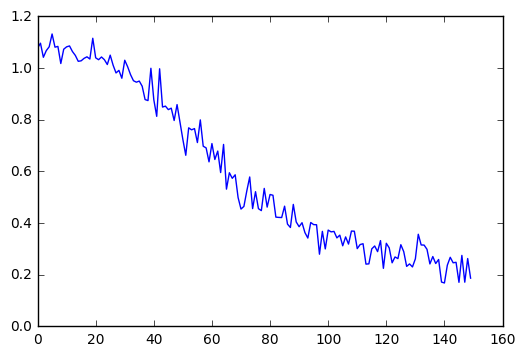

In [106]:
plt.plot(tcnn.errors_plot)

In [107]:
test_accuracy(np.argmax(tcnn.predict(TC_test), axis = 1), np.argmax(y_tc_test, axis=1))

0.96799999999999997